## LAB CHALLENGE: Neural Matrix Factorization 
In the previous lecture we have built a recommender system using the Neural Matrix Factorization framework. This framework allowed us to combine the GMF layers with the MLP layers in this way:
$$\phi^{GMF} = \mathbf{p_u}^G\odot \mathbf{q_i}^G$$
$$\phi^{MLP} = a_L(\mathbf{W}_L^T(a_{L-1}(...a_2 (\mathbf{W}_2^T \begin{bmatrix}
\mathbf{p_u} \\ \mathbf{q_i}
\end{bmatrix} + \mathbf{b}_2)...)) + \mathbf{b}_L)$$

$$ y_{ui} = \sigma(\mathbf{h}^T \begin{bmatrix}
\ \phi^{GMF} \\ \phi^{MLP}
\end{bmatrix})$$

<center>  <img src="https://drive.google.com/uc?export=view&id=1gNLUpiQdbDPMdvfZYVs3lcou3cd4Favb" width="550" height="400"> </center> 

Let's now try to apply transfer learning to such an architecture. 

- TASK 1: Train the GMF and MLP models separately, inspect and save the parameters.
- TASK 2: Use the pre-trained parameters for initializing the NMF architecture. In particular, use the pre-trained embeddings for users and items and the initialized layers of GMF and MLP.
- TASK 3: Finally, train the NMF model both by freezing the layers preceding the NeuMF layer and by keeping all the parameters trainable. Compare the performance with the network trained from scratch.


In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
#from ray import tune
#from ray.tune import CLIReporter
#from ray.tune.schedulers import ASHAScheduler
from torch.utils.data import DataLoader
import time

from neumf import NeuMF
from metrics import metrics
from NCF_Data import NCF_Data
from dl import data_loaders_from_data

/home/agoniko/Desktop/Uni/DEEP_LEARNING/Transfer Learning/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## PATH definition

In [2]:
PATH = "./ml-100k/u.data" 
MODEL_PATH = "./models/" 

## Parameters Definition

In [93]:
args = {
    "seed": 42,
    "lr": 0.03,
    "dropout": 0.0,
    "batch_size": 128,
    "epochs": 30,
    "top_k": 10,
    "num_factors": 8,
    "layers": (64, 32, 16, 8),
    "out": True,
    "num_ng": 4,
    "num_ng_test": 100
}

In [5]:
best_config = {
    "lr": 0.01,
    "batch_size": 128,
    "num_factors_gmf": 16,
    "num_factors_mlp": 64,
    "epochs": 30,
    "out": True,
    "dropout": [0, 0, 0, 0],
}

In [94]:
np.random.seed(args["seed"])
torch.manual_seed(args["seed"])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cpu')

## Load Train and Test loaders

In [96]:
# load data
ml_100k = pd.read_csv(
	PATH, 
	sep="\t", 
	names = ['user_id', 'item_id', 'rating', 'timestamp'], 
	engine='python')

# set the num_users, items
num_users = ml_100k['user_id'].nunique()+1
num_items = ml_100k['item_id'].nunique()+1

# construct the train and test datasets
data = NCF_Data(ml_100k, args)
train_loader = data.get_train_instance()
test_loader = data.get_test_instance()

# Models

In [133]:
def train_model(model: nn.Module, train_loader: DataLoader, test_loader: DataLoader, optimizer = None, name_suffix = ""):
    model = model.to(device)

    # Loss and optimizer
    loss_function = nn.BCELoss()
    if optimizer == None:
        optimizer = optim.Adam(model.parameters(), lr=args["lr"])

    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    best_hr = 0
    
    # Train cycle
    for epoch in range(args["epochs"]):
        start_time = time.time()
        
        # Train step
        model.train()

        for user, item, label in train_loader:
            user = user.to(device)
            item = item.to(device)
            label = label.to(device)

            # Zero grad
            optimizer.zero_grad()
            
            # Prediction
            prediction = model(user, item)
            loss = loss_function(prediction, label)
            
            # Backpropagation
            loss.backward()
            optimizer.step()
            
        scheduler.step()
        # Eval metrics
        model.eval()
        HR, NDCG = metrics(model, test_loader, args["top_k"], device)

        # Print metrics and time elapsed
        elapsed_time = time.time() - start_time
        print(
            "Epoch {:03d}".format(epoch)
            + " time to train: "
            + time.strftime("%H: %M: %S", time.gmtime(elapsed_time))
            + " LR: {:.3f}".format(scheduler.get_last_lr()[0]) 
        )

        print("HR: {:.3f}\tNDCG: {:.3f}".format(np.mean(HR), np.mean(NDCG)))

        # If best model, save it
        if HR > best_hr:
            best_hr, best_ndcg, best_epoch = HR, NDCG, epoch
            if args["out"]:
                if not os.path.exists(MODEL_PATH):
                    os.mkdir(MODEL_PATH)
                torch.save(
                    model, "{}{}{}{}.pt".format(MODEL_PATH, model.__class__.__name__, model.num_factors, name_suffix)
                )


## GMF model

In [ ]:
class GMF(nn.Module):
    def __init__(self, num_users, num_items):
        super(GMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.num_factors = args["num_factors"]

        self.embedding_user = nn.Embedding(
            num_embeddings=self.num_users, embedding_dim=self.num_factors
        )
        self.embedding_item = nn.Embedding(
            num_embeddings=self.num_items, embedding_dim=self.num_factors
        )

        self.affine_output = nn.Linear(in_features=self.num_factors, out_features=1)
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        element_product = torch.mul(user_embedding, item_embedding)
        logits = self.affine_output(element_product)
        rating = self.logistic(logits)
        return rating.squeeze()


In [ ]:
args["lr"] = 0.01
args["dropout"] = 0
args["num_factors"] = 8
gmf_model = GMF(num_users, num_items)
train_model(gmf_model, train_loader, test_loader)
#gmf_model = torch.load(MODEL_PATH + "GMF8.pt", map_location=device)

## MLP model

In [58]:
class MLP(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(MLP, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.num_factors = args["num_factors"]
        self.layers = args["layers"]

        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.num_factors)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.num_factors)

        self.fc_layers = nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(self.layers[:-1], self.layers[1:])):
            self.fc_layers.append(nn.Linear(in_size, out_size))

        self.affine_output = nn.Linear(in_features=self.layers[-1], out_features=1)
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        vector = torch.cat([user_embedding, item_embedding], dim=-1)  # the concat latent vector
        for idx, _ in enumerate(range(len(self.fc_layers))):
            vector = self.fc_layers[idx](vector)
            vector = nn.ReLU()(vector)
            # vector = nn.BatchNorm1d()(vector)
            # vector = nn.Dropout(p=0.5)(vector)
        logits = self.affine_output(vector)
        rating = self.logistic(logits)
        return rating.squeeze()

    def init_weight(self):
        pass

In [ ]:
args["lr"] = 0.01
args["dropout"] = 0
args["num_factors"] = 64
args['layers'] = [128, 64, 32, 16, 8]
mlp_model = MLP(args, num_users, num_items)
train_model(mlp_model, train_loader, test_loader)
#mlp_model = torch.load(MODEL_PATH + "MLP64.pt", map_location=device)

## NeuMF model

In [97]:
nmf_model = torch.load(MODEL_PATH + "Assignment 1 - best.pt", map_location=device)
#nmf_model = NeuMF(gmf_model.num_factors, mlp_model.num_factors, num_users, num_items)
#train_model(nmf_model, train_loader, test_loader)

# Defining functions that load sub_models weights

In [98]:
def load_gmf_weights(nmf_model, gmf_model, requires_grad=False):
    nmf_layers_names = [name for name, _ in nmf_model.named_parameters()]
    gmf_layers_names = [name for name, _ in gmf_model.named_parameters()]
    #create a dict that has as key the value of the layer in the NMF model and as value the layer in the GMF model
    layers_name_match_dict = {k: v for k, v in zip(nmf_layers_names[:2], gmf_layers_names)}
    for nmf_layer_name, gmf_layer_name in layers_name_match_dict.items():
        nmf_model.state_dict()[nmf_layer_name].copy_(gmf_model.state_dict()[gmf_layer_name])
    #deactivate grad for the layers that comes from the GMF model
    for name, param in nmf_model.named_parameters():
        if name in layers_name_match_dict.keys():
            param.requires_grad = requires_grad


def load_mlp_weights(nmf_model, mlp_model, requires_grad=False):
    nmf_layers_names = [name for name, _ in nmf_model.named_parameters()]
    mlp_layers_names = [name for name, _ in mlp_model.named_parameters()]
    #create a dict that has as key the value of the layer in the NMF model and as value the layer in the MLP model
    layers_name_match_dict = {k: v for k, v in zip(nmf_layers_names[4:], mlp_layers_names[:-2])}
    for nmf_layer_name, mlp_layer_name in layers_name_match_dict.items():
        nmf_model.state_dict()[nmf_layer_name].copy_(mlp_model.state_dict()[mlp_layer_name])
    #deactivate grad for the layers that comes from the MLP model
    for name, param in nmf_model.named_parameters():
        if name in layers_name_match_dict.keys():
            param.requires_grad = requires_grad


def load_pre_trained_weights(nmf_model, gmf_model, mlp_model, requires_grad = False):
    load_gmf_weights(nmf_model, gmf_model, requires_grad)
    load_mlp_weights(nmf_model, mlp_model, requires_grad)

# Performance with sum_models layers freezed

In [122]:
nmf_model = NeuMF(gmf_model.num_factors, mlp_model.num_factors, num_users, num_items)

In [123]:
list(nmf_model.named_parameters())[0][1]

Parameter containing:
tensor([[ 1.1476,  0.9796,  0.6913,  ..., -0.0891,  0.8731, -1.1423],
        [ 0.9411,  0.9341, -1.2894,  ..., -0.2198, -1.1808,  0.7464],
        [ 1.5897,  2.2607,  0.8680,  ..., -0.6446, -1.1341,  3.1922],
        ...,
        [ 0.5411,  1.7417, -0.4697,  ..., -0.6935,  0.8524, -0.3464],
        [ 0.2462,  1.2939,  1.8231,  ..., -0.9035, -0.1719,  0.5580],
        [ 0.8268,  1.3029,  0.7328,  ...,  0.7961, -0.8704, -0.7364]],
       requires_grad=True)

In [124]:
load_pre_trained_weights(nmf_model, gmf_model, mlp_model, requires_grad=False)

In [125]:
list(nmf_model.named_parameters())[0][1]


Parameter containing:
tensor([[ 4.6771,  1.1632,  1.5885,  ...,  1.3986,  0.4661,  2.3601],
        [-1.3151, -1.2802, -2.5274,  ..., -2.6559, -1.8792,  0.8724],
        [ 2.0693, -2.1636,  1.2961,  ..., -1.0367,  3.5497, -0.7432],
        ...,
        [-0.2371, -0.5420, -4.3220,  ...,  1.8953,  1.1341, -1.7264],
        [ 2.7540, -2.3100, -1.2324,  ...,  1.2221, -1.8173,  2.6105],
        [ 0.2497, -0.4265,  0.6371,  ...,  0.7272, -0.4906, -0.9946]])

In [126]:
for name, param in nmf_model.named_parameters():
    print(name, param.requires_grad)

gmf_user_embed.0.weight False
gmf_item_embed.0.weight False
gmf_affine.weight True
gmf_affine.bias True
mlp_user_embed.0.weight False
mlp_item_embed.0.weight False
mlp_fc.0.weight False
mlp_fc.0.bias False
mlp_fc.3.weight False
mlp_fc.3.bias False
mlp_fc.6.weight False
mlp_fc.6.bias False
mlp_fc.9.weight False
mlp_fc.9.bias False
mixing_layers.0.weight True
mixing_layers.0.bias True
mixing_layers.3.weight True
mixing_layers.3.bias True
mixing_layers.6.weight True
mixing_layers.6.bias True


In [134]:
args["lr"] = 0.03
train_model(nmf_model, train_loader, test_loader, name_suffix="-freezed4205")

ValueError: Unknown format code 'd' for object of type 'float'

# Performance letting initialized layers free

In [131]:
nmf_model = NeuMF(gmf_model.num_factors, mlp_model.num_factors, num_users, num_items)
#nmf_model = torch.load(MODEL_PATH + "NeuMF64-freezed.pt", map_location=device)
load_pre_trained_weights(nmf_model, gmf_model, mlp_model, requires_grad=True)
for name, param in nmf_model.named_parameters():
    print(name, param.requires_grad)

gmf_user_embed.0.weight True
gmf_item_embed.0.weight True
gmf_affine.weight True
gmf_affine.bias True
mlp_user_embed.0.weight True
mlp_item_embed.0.weight True
mlp_fc.0.weight True
mlp_fc.0.bias True
mlp_fc.3.weight True
mlp_fc.3.bias True
mlp_fc.6.weight True
mlp_fc.6.bias True
mlp_fc.9.weight True
mlp_fc.9.bias True
mixing_layers.0.weight True
mixing_layers.0.bias True
mixing_layers.3.weight True
mixing_layers.3.bias True
mixing_layers.6.weight True
mixing_layers.6.bias True


In [132]:
args["lr"] = 0.02
train_model(nmf_model, train_loader, test_loader, name_suffix="-free42")

Epoch 000 time to train: 00: 00: 18LR: 0.018000000000000002
HR: 0.607	NDCG: 0.359
Epoch 001 time to train: 00: 00: 20LR: 0.016200000000000003
HR: 0.626	NDCG: 0.359


KeyboardInterrupt: 

# Performance comparison

In [107]:
nmf_freezed = torch.load(MODEL_PATH + "NeuMF64-freezed4205.pt", map_location = device)
gmf_best = torch.load(MODEL_PATH + "GMF8.pt", map_location = device)
mlp_best = torch.load(MODEL_PATH + "MLP64.pt", map_location = device)
nmf_free = torch.load(MODEL_PATH + "NeuMF64-free42.pt", map_location = device)
nmf_init = torch.load(MODEL_PATH + "Assignment 1 - best.pt", map_location=device)

nmf_freezed.to(device) 
gmf_best.to(device) 
mlp_best.to(device)
nmf_free.to(device) 
nmf_init.to(device)

HR, NDCG = {}, {}
HR['NeuMF - freezed'], NDCG['NeuMF - freezed'] = metrics(nmf_freezed, test_loader, 10, device)
HR['NeuMF - free'], NDCG['NeuMF - free'] = metrics(nmf_free, test_loader, 10, device)
HR['NeuMF - init'], NDCG['NeuMF - init'] = metrics(nmf_init, test_loader, 10, device)
HR['GMF'], NDCG['GMF'] = metrics(gmf_best, test_loader, 10, device)
HR['MLP'], NDCG['MLP'] = metrics(mlp_best, test_loader, 10, device)

Text(0.5, 1.0, 'Best NDCG across models')

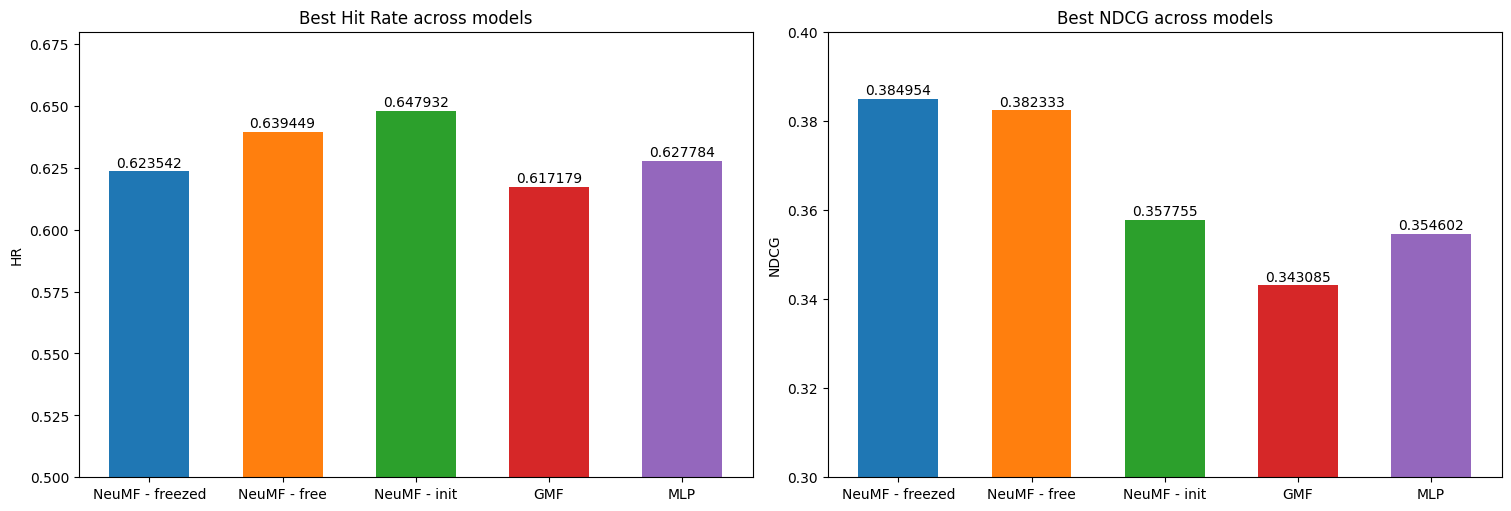

In [108]:
fig, ax = plt.subplots(1, 2, layout = "constrained", figsize = (15, 5))
for model, value in HR.items():
    rect = ax[0].bar(model, value, width= 0.6)
    ax[0].bar_label(rect, padding = 1)

ax[0].set_ylabel("HR")
ax[0].set_ylim(0.5, 0.68)
ax[0].set_title("Best Hit Rate across models")

for model, value in NDCG.items():
    rect = ax[1].bar(model, value, width= 0.6)
    ax[1].bar_label(rect, padding = 1)

ax[1].set_ylabel("NDCG")
ax[1].set_ylim(0.3, 0.40)
ax[1].set_title("Best NDCG across models")